```
• Implement Clustering: Use algorithms like Kmeans to detect natural
clusters in the Twitter data.
• Classify Sentiments: Apply SVM and RNN for unsupervised sentiment
classification.
• Performance Metrics: Evaluate models based on accuracy, precision,
recall, and F1 score.
```

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import tensorflow

In [15]:
file_name = os.path.join(os.getcwd(),  'sentiment_analysis.csv')
df = pd.read_csv(file_name)
df = df.drop(columns=['id'])
df.head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


In [16]:
def clean(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    # text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\n',' ', text)  # Remove line breaks
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove punctuation
    text = text.lower()  # Lowercase

    filtered_text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

    return filtered_text

# Function to extract hashtags from a tweet
def extract_hashtags(tweet):
    hashtags = re.findall(r'#(\w+)', tweet)
    return hashtags

# Apply the function to extract hashtags and create a new column
df['hashtags'] = df['tweet'].apply(extract_hashtags)

df['cleaned_tweet'] = df['tweet'].apply(clean)

In [17]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned_tweet'])

# Applying K-means clustering
k = 5  # Number of clusters
model = KMeans(n_clusters=k, random_state=42)
model.fit(X)

# Assigning cluster labels to the data points
df['cluster'] = model.labels_

# Analyze cluster centroids (to find top terms per cluster)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {top_terms}")

# View the data with clusters
print(df[['tweet', 'cluster']].head())

Cluster 0: ['apple', 'iphone', 'ios', 'ipad', 'new', 'mac', 'just', 'phone', 'fuck', 'fucking']
Cluster 1: ['iphone', 'love', 'cute', 'ipad', 'instagram', 'like', 'news', 'fashion', 'instagood', 'case']
Cluster 2: ['sony', 'samsung', 'ps', 'new', 'smile', 'camera', 'music', 'ipod', 'im', 'just']
Cluster 3: ['phone', 'new', 'samsung', 'galaxy', 'note', 'got', 'iphone', 'finally', 'android', 'case']
Cluster 4: ['follow', 'gain', 'rt', 'sougofollow', 'rts', 'followers', 'iphone', 'sup', 'surf', 'capetown']
                                               tweet  cluster
0  #fingerprint #Pregnancy Test https://goo.gl/h1...        1
1  Finally a transparant silicon case ^^ Thanks t...        2
2  We love this! Would you go? #talk #makememorie...        1
3  I'm wired I know I'm George I was made that wa...        1
4  What amazing service! Apple won't even talk to...        0


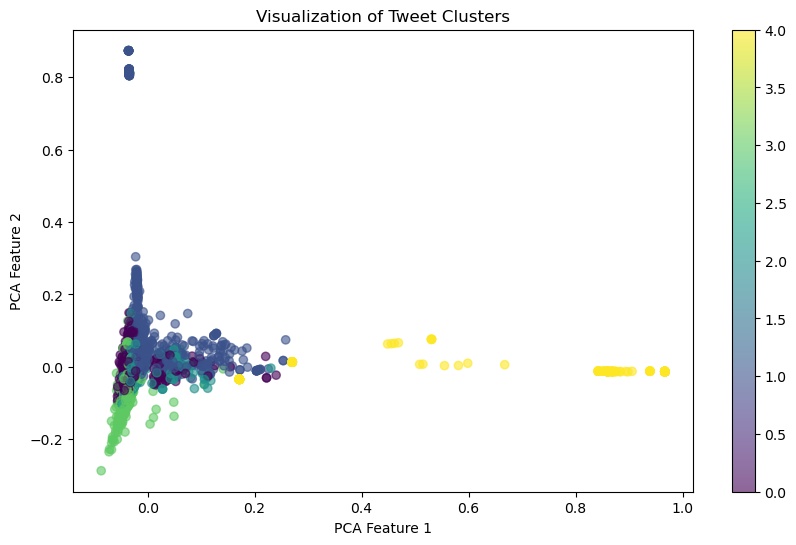

In [18]:
# Visualization of Clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X.toarray())

# Scatter plot of the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.title('Visualization of Tweet Clusters')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(scatter)
plt.show()

In [19]:
# Performance Metrics: Evaluate models based on accuracy, precision, recall, and F1 score.
performance_data = {}

In [20]:
# SVM Based approach:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Step 1: Split the dataset into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Step 2: Feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train = tfidf_vectorizer.fit_transform(train_df['tweet'])
y_train = train_df['label']
X_val = tfidf_vectorizer.transform(val_df['tweet'])
y_val = val_df['label']
X_test = tfidf_vectorizer.transform(test_df['tweet'])
y_test = test_df['label']

# Step 3: Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can try different kernels and hyperparameters
svm_model.fit(X_train, y_train)

# Step 4: Validate the model
y_val_pred = svm_model.predict(X_val)
val_accuracy = (y_val_pred == y_val).mean()
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')
performance_data['SVM'] = [val_accuracy, val_precision, val_recall, val_f1]

# Step 5: Test the model
y_test_pred = svm_model.predict(X_test)
test_accuracy = (y_test_pred == y_test).mean()
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')
performance_data['SVM'] = [test_accuracy, test_precision, test_recall, test_f1]


In [21]:
# LSTM Code

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]
        vectorized_text = self.tokenizer.transform([text]).toarray()
        return torch.FloatTensor(vectorized_text), torch.tensor(label)

# Read the data
X = df['tweet'].values
y = df['label'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

# Define hyperparameters
input_size = len(vectorizer.get_feature_names_out())
hidden_size = 128
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 10
batch_size = 32

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Prepare data loaders
train_dataset = CustomDataset(X_train, y_train, vectorizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training the model
total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

# Prepare the test dataset
test_dataset = CustomDataset(X_test, y_test, vectorizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predictions = []
    # Ensure test_loader is defined as shown above
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float().to(device)
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().detach().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='binary')
    accuracy = correct / total
    performance_data['LSTM'] = [accuracy, precision, recall, f1]


Epoch [1/10], Step [100/198], Loss: 0.2955
Epoch [2/10], Step [100/198], Loss: 0.1323
Epoch [3/10], Step [100/198], Loss: 0.0930
Epoch [4/10], Step [100/198], Loss: 0.0923
Epoch [5/10], Step [100/198], Loss: 0.0007
Epoch [6/10], Step [100/198], Loss: 0.0004
Epoch [7/10], Step [100/198], Loss: 0.0000
Epoch [8/10], Step [100/198], Loss: 0.0001
Epoch [9/10], Step [100/198], Loss: 0.0002
Epoch [10/10], Step [100/198], Loss: 0.0003


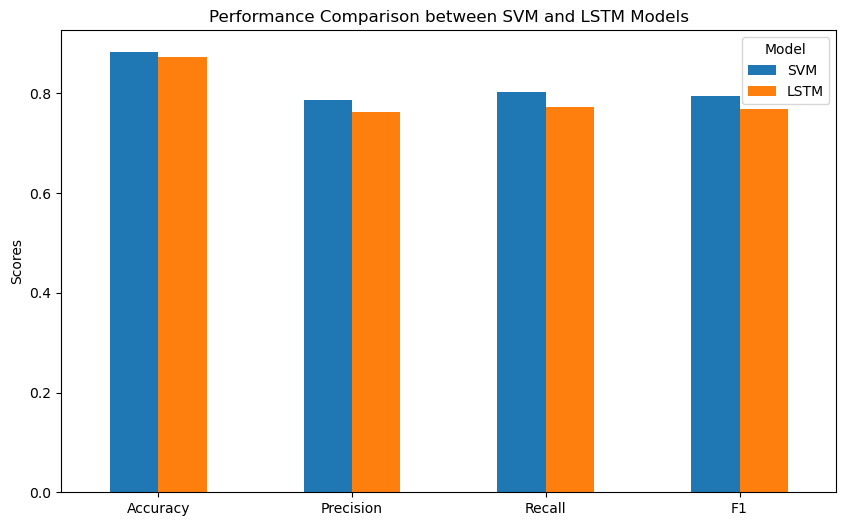

In [22]:
import pandas as pd

performance_df = pd.DataFrame(performance_data, index=['Accuracy', 'Precision', 'Recall', 'F1'])
performance_df.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison between SVM and LSTM Models')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.show()

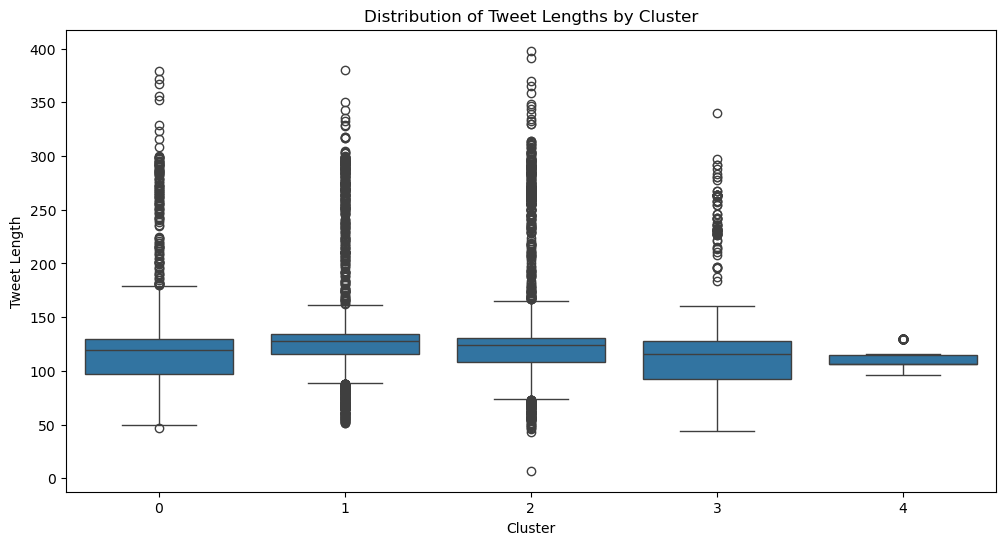

In [24]:
# Calculate tweet lengths and visualize
df['tweet_length'] = df['tweet'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='tweet_length', data=df)
plt.title('Distribution of Tweet Lengths by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Tweet Length')
plt.show()